# Import

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
from torch import FloatTensor, LongTensor
import math

In [3]:
from load_script_deep_framework import load_dataset

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch.nn as nn

In [53]:
'Dataset plotting function'
def plot_output(train, all_output, permutation):
    plt.figure(figsize=(3,3))
    plt.scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)

# Loading the dataset

In [6]:
train,target_train = load_dataset()

In [7]:
test,target_test = load_dataset()

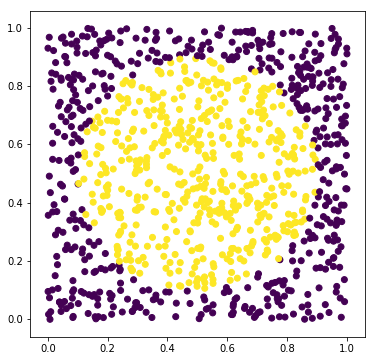

In [51]:
plt.figure(figsize=(6,6))
plt.scatter(test[:,0], test[:,1], c=target_test[:,1].numpy())

# Generic Module Class

In [9]:
class Module():
    
    def forward(self,input):
        raise NotImplemented
        
    def backward(self,input):
        raise NotImplemented
            
    def param(self):
        return
    
    def __call__(self, *input):
        return self.forward(*input)
    
    def zero_grad_(self):
        return
    
    def update_weights_(self, learning_rate):
        return

# Specific classes

In [16]:
class Linear(Module):
    
    def __init__(self, input_dimension ,output_dimension):
        super(Linear,self).__init__()
        
        # Append 1 to input for bias term
        self._input_dimension = input_dimension
        self._output_dimension = output_dimension
    
        self._weights = torch.randn(self._output_dimension, self._input_dimension + 1)*1e-1

        self._gradient = torch.zeros(self._weights.shape)
    
    def forward(self, input):
        self._input = torch.cat((torch.Tensor([1]), input.view(-1)))
        self._output = self._weights.mv(self._input)
        
        return self._output.clone()
        
    def backward(self, d_dy):
        self._gradient.add_(d_dy.view(-1,1) * self._input.view(1,-1))
        d_dx = self._weights.narrow(1, 1, self._input_dimension).t().mv(d_dy)
        
        return d_dx
    
    def param(self):
        return self._weights, self._gradient
    
    def zero_grad_(self):
        self._gradient.zero_()
        
    def update_weights_(self, learning_rate):
        self._weights.add_(- learning_rate * self._gradient)
    

In [17]:
class ReLU(Module):
    
    def __init__(self):
        super(ReLU,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.clone()
        self._output[self._output < 0] = 0

        return self._output.clone()
    
    def backward(self,d_dy):
        
        d_dx = d_dy.clone()
        d_dx[self._input < 0] = 0
        
        return d_dx
        

In [18]:
class Tanh(Module):
    def __init__(self):
        super(Tanh,self).__init__()
        
    def forward(self,input):
        self._input = input.clone()
        
        self._output = self._input.tanh()
        
        return self._output.clone()
    
    def backward(self,d_dy):
        d_dx= (1 - self._input.tanh()**2) * d_dy
        
        return d_dx
        

In [19]:
class LossMSE(Module):
    def __init__(self):
        super(LossMSE,self).__init__()
        
    def forward(self, input, target):
        self._input = input - target
        self._output = (self._input).pow(2).sum()
        return self._output
        
    def backward(self):
        d_dy = 2 * self._input
        return d_dy

In [20]:
class Sequential(Module):
    def __init__(self, modules ,loss):
        super(Sequential,self).__init__()
        
        self._modules = modules
        self._loss = loss
    
    def forward(self, input, target):
        
        y = input.clone()
        for module in self._modules:
            y = module(y)
        
        output = y.clone()
        
        loss = self._loss(y, target)
        
        return loss, output
    
    def backward(self):
        d_dy = self._loss.backward()
        
        for module in reversed(self._modules):
            d_dy = module.backward(d_dy)
            
            
    def zero_grad_(self):
        for module in self._modules:
            module.zero_grad_()

    def update_weights_(self,learning_rate):
        for module in self._modules:
            module.update_weights_(learning_rate)

Test error 51.1 %
Test error 48.9 %
Test error 51.1 %
Test error 51.1 %
Test error 48.9 %
Test error 48.8 %
Test error 19.6 %
Test error 13.5 %
Test error 8.3 %
Test error 7.3 %
Test error 5.1 %
Test error 13.600000000000001 %
Test error 6.7 %
Test error 5.2 %
Test error 20.4 %
Test error 7.3999999999999995 %
Test error 6.4 %
Test error 8.799999999999999 %
Test error 8.4 %
Test error 4.3999999999999995 %
Test error 5.2 %
Test error 6.4 %
Test error 9.2 %
Test error 5.800000000000001 %
Test error 6.3 %
Test error 6.1 %
Test error 3.1 %
Test error 4.0 %
Test error 8.200000000000001 %
Test error 6.4 %
Test error 7.3999999999999995 %
Test error 9.4 %
Test error 4.8 %
Test error 3.5999999999999996 %
Test error 7.6 %
Test error 4.1000000000000005 %
Test error 4.6 %
Test error 6.1 %
Test error 6.6000000000000005 %
Test error 2.7 %
Test error 4.5 %
Test error 4.6 %
Test error 7.199999999999999 %
Test error 5.6000000000000005 %
Test error 3.8 %
Test error 5.5 %
Test error 8.1 %
Test error 2.5 %

Test error 1.5 %
Test error 1.5 %
Test error 1.4000000000000001 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.4000000000000001 %
Test error 1.4000000000000001 %
Test error 1.3 %
Test error 1.5 %
Test error 1.4000000000000001 %
Test error 1.5 %
Test error 1.7000000000000002 %
Test error 1.4000000000000001 %
Test error 1.6 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.4000000000000001 %
Test error 1.5 %
Test error 1.5 %
Test error 1.4000000000000001 %
Test error 1.4000000000000001 %
Test error 1.4000000000000001 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.7000000000000002 %
Test error 1.4000000000000001 %
Test error 1.5 %
Test error 1.5 %
Test error 1.3 %
Test error 1.5 %
Test error 1.3 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.5 %
Test error 1.4000000000000001 %
Test error 1.5 %
Test error 1.5 %
Test error 1.4000000000000001 %
Test error 1.5 %
Test err

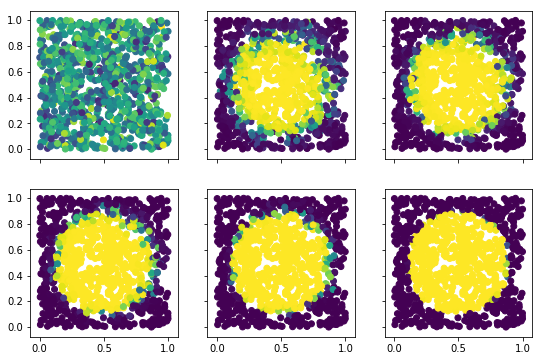

In [68]:
# Define Neural Network
layers = [
    Linear(2,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,25),
    ReLU(),
    Linear(25,2),
    Tanh()
]
loss_function = LossMSE()
network = Sequential(layers, loss_function)

learning_rate = 1e-2
num_epochs = 500

train_loss = []
test_correct = []

# Define subplot for dataset visualization
fig, axes = plt.subplots(nrows = 2, ncols = 3, sharex = True, sharey = True, figsize = (9, 6))
ind = 0

for epoch in range(num_epochs):
    
    correct = 0
    all_output = []
    loss_sum = 0
    
    # Randomize order SGD
    permutation = torch.randperm(target_train.shape[0])

    for j, pair in enumerate(zip(train[permutation],target_train[permutation])):
        
        # Load sample
        train_element, target_element = pair
        
        # Forward pass
        loss, output = network(train_element, target_element)
        loss_sum += loss

        # Backward pass, gradient step and reinitalize gradient
        network.backward()
        network.update_weights_(learning_rate)
        network.zero_grad_()

        # Training error
        boolean_target = target_element[1] > target_element[0]
        boolean_output = output[1] > output[0]
        
        all_output.append(output.numpy().tolist()[1])
        
        if boolean_target == boolean_output:
            correct += 1
        
    train_loss.append(loss_sum)
    learning_rate *= 0.99
    
    if epoch % 1 == 0:
        #print('Epoch: {}. Train error: {} %'.format(epoch ,(1000-correct)/1000*100))
        
        test_correct.append(test_error())
        
    if epoch in [1, 15, 25, 50, 100, 499]:
        axes[ind // 3, ind % 3].scatter(train[permutation][:,0], train[permutation][:,1], c = all_output)
        ind += 1

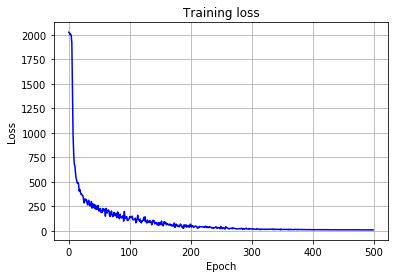

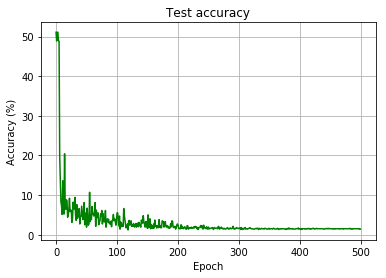

In [70]:
plt.figure("Train Loss")
plt.title("Training loss")
plt.plot(train_loss, 'b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
#plt.savefig("figures/loss_2.eps", format="eps")

plt.figure("Test accuracy")
plt.title("Test accuracy")
plt.plot(test_correct, 'green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.savefig("figures/accuracy.eps", format="eps")

# Test

In [67]:
def test_error():
    correct_test = 0

    for j, pair in enumerate(zip(test,target_test)):

        # Load test sample
        test_element, target_test_element = pair

        # Forward pass
        loss, output = network(test_element, target_test_element)

        boolean_target = target_test_element[1] > target_test_element[0]

        boolean_output = output[1] > output[0]

        if boolean_target == boolean_output:
            correct_test += 1 

    correct_test = (1000-correct_test)/1000 * 100
    print('Test error {} %'.format(correct_test))
    
    return correct_test